In this notebook, we will import the overall transaction data from loyalty users and do the necessary cleaning and feature engineering for the modeling.
Due to data privacy, we limit the outputs of some cells to avoid revelance.

### Data Import, Cleaning and Exploration

In [ ]:
#import necessary packages
import pandas as pd
import pickle
import numpy as np
from scipy import stats

from keras.preprocessing.sequence import pad_sequences
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GroupShuffleSplit

import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

Loyalty card transaction data is often large and therefore it is best to store in a cloud space in a compressed format. In this thesis, we store the data in Google Drive for its conveniency with Google Colab. Due to data privacy concerns, the data used in this thesis is not to be shared. However, we provide an example to upload such data from Google Drive.

In [ ]:
#import transactions data from drive
data = drive.CreateFile({'id': 'here provide the file id from link sharing in from google drive'})
data.GetContentFile('loyalty_card_data.gz')
data = pd.read_csv('loyalty_card_data.gz', sep='|')

In [ ]:
#we delete the unused columns, and drop duplicated entries in the same shopping trip
del data['store_id'], data['till_id'], data['gtin'], data['timestamp']
data = data.drop_duplicates()

In [ ]:
# get product attributes data
products = drive.CreateFile({'id': 'here provide the file id from link sharing in from google drive'})
products.GetContentFile('product_attributes_data.tsv.gz')
products = pd.read_table('product_attributes_data.tsv.gz')

In [ ]:
#cleaning out products with zero or negative price
data = data.loc[data['price'] >= 0.01] 
data['price'] = pd.Series(data['price'], dtype="float")

### Total Data Basket and Sales Distributions

We will check the basket size distributions. Below we see that there are few outliers with very large basket and furthermore, ~98% of the baskets hold less than 35 products.

8.630699140624266


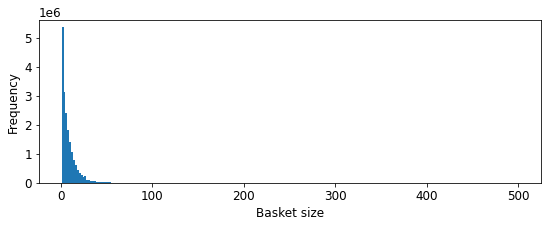

In [ ]:
basket_length = data.groupby('basket_hash', as_index=False).aggregate({'product_id': 'count'})
print(basket_length['product_id'].mean())
import matplotlib.pyplot as plt
plt.figure(figsize=(9,3))
font = {'size'   : 12}

plt.rc('font', **font)
plt.ylabel("Frequency")
plt.xlabel("Basket size")
#plt.title("Item Rank, Frequency (total data) ")
plt.hist(basket_length['product_id'], bins=240)

plt.show()

In [ ]:
basket_length[basket_length['product_id'] < 35].shape[0] / basket_length.shape[0]

0.9824374801132588

Moreover, we check the distribution of sales to see if it shows long-tail distribution.

In [ ]:
popularity_ranking = data[['total_prod_freq', 'product_id']].drop_duplicates().sort_values(by='total_prod_freq', ascending=False).reset_index(drop=True)
popularity_ranking['item_rank'] = popularity_ranking.index + 1

<BarContainer object of 34810 artists>

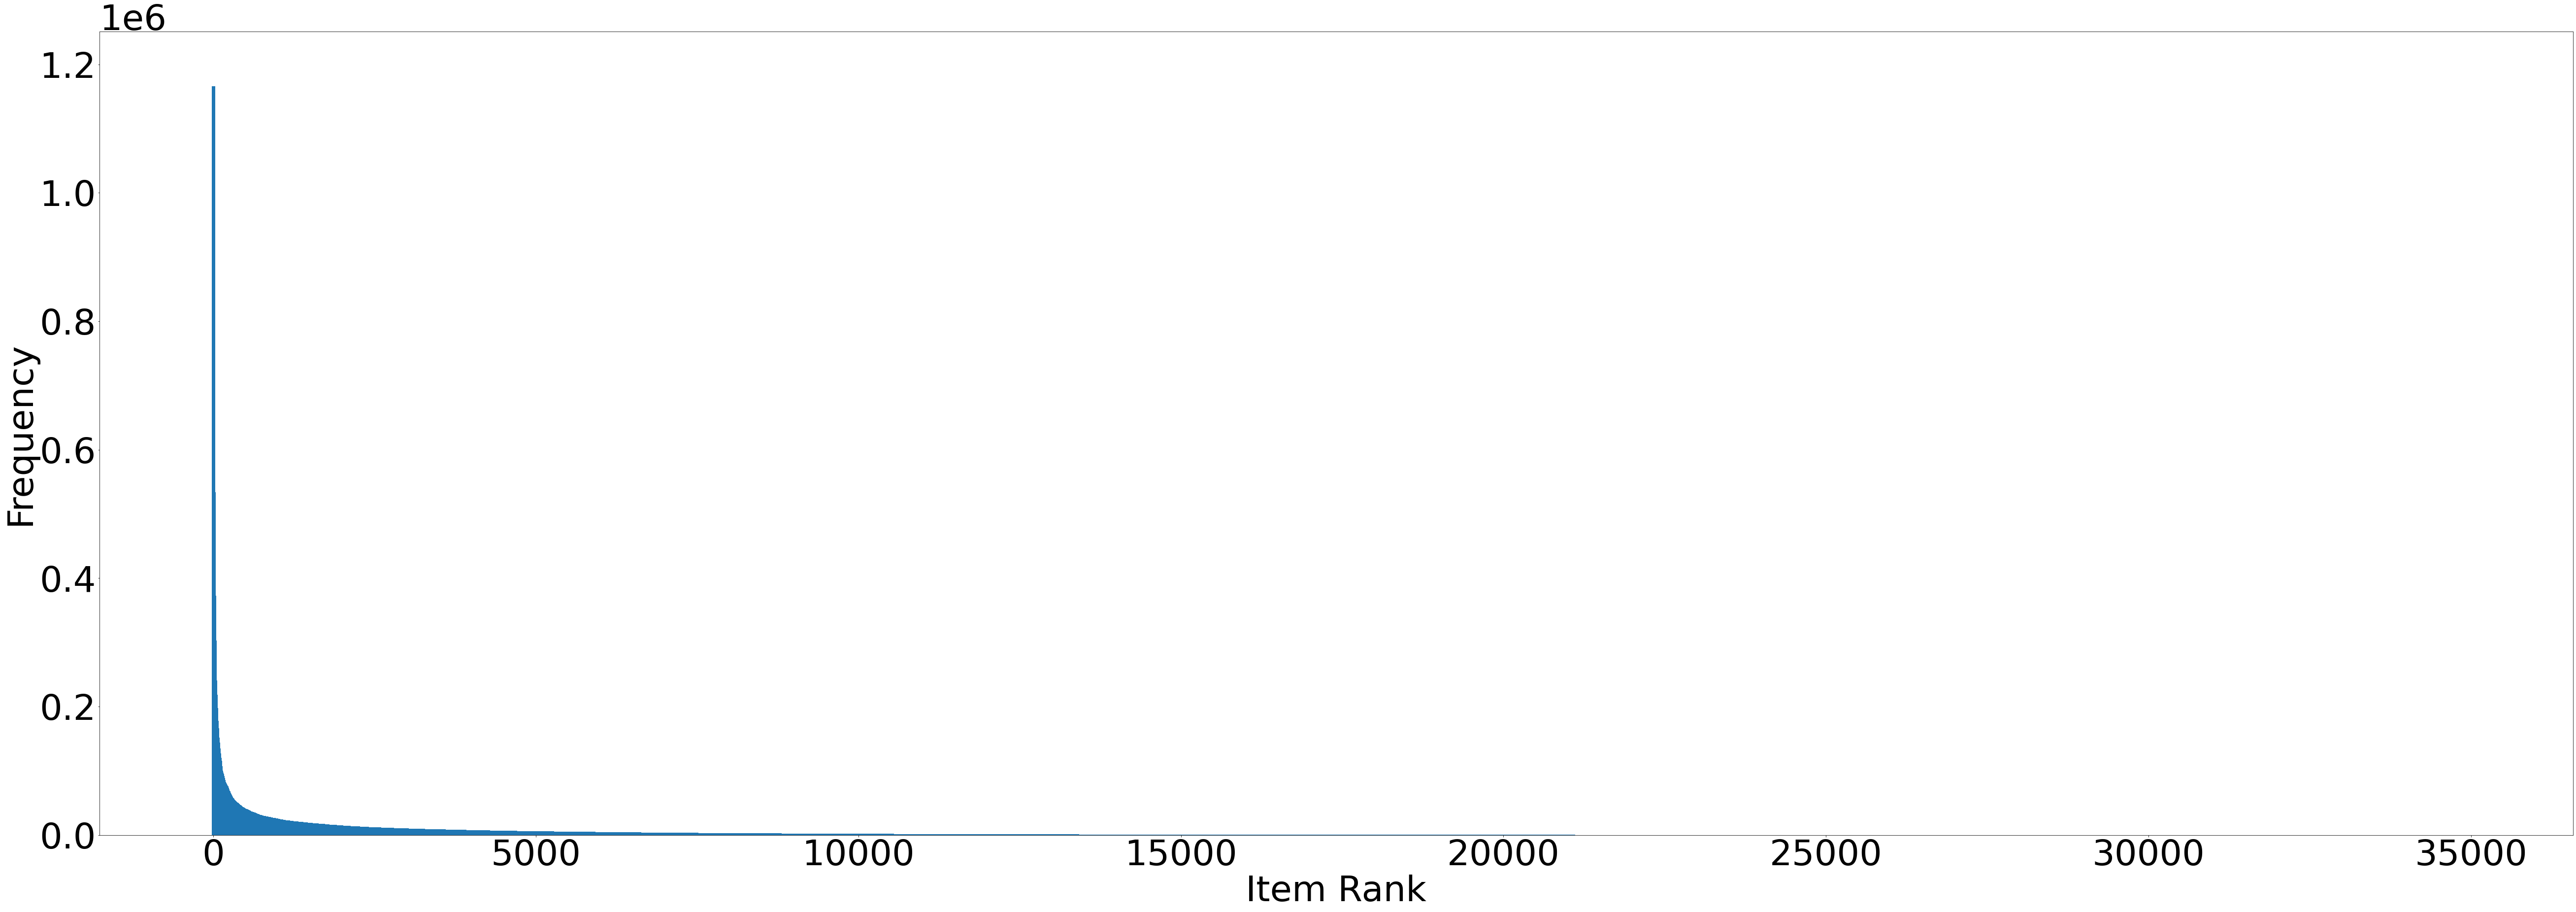

In [ ]:
plt.figure(figsize=(90,30))
font = {'size'   : 72}

plt.rc('font', **font)
plt.ylim([0, 1251086])
plt.ylabel("Frequency")
plt.xlabel("Item Rank")
#plt.title("Item Rank, Frequency (total data) ")
plt.bar(popularity_ranking['item_rank'], popularity_ranking['total_prod_freq'], width=50.8)

In [ ]:
popularity_ranking['cumulative_popularity'] = np.cumsum(popularity_ranking['total_prod_freq'])
total_sales = popularity_ranking['total_prod_freq'].sum()
popularity_ranking['percentage_of_sales'] = popularity_ranking['cumulative_popularity'] / total_sales
popularity_ranking[popularity_ranking['item_rank'] < max(popularity_ranking['item_rank'] / 5)]


*   10% of all products represent ~73% of total sales
*   20% of all products represent ~87% percent of total sales
*   50% of all products represent 98% of total sales



From the top 10 seller categories, we evaluate the importance of long-tail sales share and their roles in the assortment.

In [ ]:
products.rename(columns={'rpid' : 'product_id'}, inplace=True)
products = products[['product_id', 'article_text', 'subcategory_name', 'category_name']]
data_rank = data[['product_id', 'total_prod_freq']]

In [ ]:
data_rank = data_rank[['total_prod_freq', 'product_id']].drop_duplicates().sort_values(by='total_prod_freq', ascending=False).reset_index(drop=True)
data_rank['item_rank'] = data_rank.index + 1 #creating item ranks to show in distribution
merged_data = pd.merge(data_rank, products, how='left', on=['product_id'])
merged_data = merged_data.drop_duplicates()
# adding long-tail distinction in the overall data
merged_data['long-tail'] = np.where(merged_data['item_rank'] < 6961, 'blockbuster', 'long-tail')

In [ ]:
categories_assortment = merged_data.groupby(['category_name'], as_index=False).aggregate(
    {
     'product_id'  : 'count'})
categories_assortment.rename(columns=({'product_id' : 'assortment_size'}), inplace=True)
categories_assortment_tail = merged_data.groupby(['category_name', 'long-tail'], as_index=False).aggregate(
    {
     'product_id'  : 'count'})
categories_assortment_tail.rename(columns=({'product_id' : 'assortment_size_tail'}), inplace=True)
categories_assortment_tail = categories_assortment_tail[categories_assortment_tail['long-tail'] == 'long-tail']
categories_assortment = pd.merge(categories_assortment, categories_assortment_tail, how='left', on=['category_name'])
categories_assortment['long-tail_assortment_share'] = categories_assortment['assortment_size_tail'] / categories_assortment['assortment_size']

In [ ]:
categories_sales = merged_data.groupby(['category_name'], as_index=False).aggregate(
    {
     'total_prod_freq'  : 'sum'})
categories_sales.rename(columns=({'total_prod_freq' : 'assortment_sales'}), inplace=True)
categories_sales_tail = merged_data.groupby(['category_name', 'long-tail'], as_index=False).aggregate(
    {
     'total_prod_freq'  : 'sum'})
categories_sales_tail.rename(columns=({'total_prod_freq' : 'assortment_sales_tail'}), inplace=True)
categories_sales_tail = categories_sales_tail[categories_sales_tail['long-tail'] == 'long-tail']
categories_sales = pd.merge(categories_sales, categories_sales_tail, how='left', on=['category_name'])
categories_sales['long-tail_assortment_sales_share'] = categories_sales['assortment_sales_tail'] / categories_sales['assortment_sales']
categories = pd.merge(categories_sales, categories_assortment, how='left', on=['category_name'])

In [ ]:
categories.sort_values(by='assortment_sales', ascending=False).head(10)

,category_name,assortment_sales,long-tail_x,assortment_sales_tail,long-tail_assortment_sales_share,assortment_size,long-tail_y,assortment_size_tail,long-tail_assortment_share
72,milk,11703689,long-tail,304350,0.026005,660,long-tail,276,0.418182
104,vegetables,10491058,long-tail,234105,0.022315,492,long-tail,325,0.660569
62,fruits,9300982,long-tail,208582,0.022426,418,long-tail,278,0.665072
108,yogurt_cream_cheese,7617848,long-tail,622362,0.081698,892,long-tail,457,0.512332
19,cheese,7370500,long-tail,538466,0.073057,988,long-tail,648,0.655870
71,meat_sausages,7199945,long-tail,541075,0.075150,1421,long-tail,1060,0.745954
34,deli_counter_bread,5173332,long-tail,200627,0.038781,650,long-tail,504,0.775385
92,soft_drinks,4657300,long-tail,341796,0.073389,834,long-tail,579,0.694245
4,beer,4558961,long-tail,388476,0.085212,827,long-tail,607,0.733978
106,water,3816750,long-tail,245571,0.064340,536,long-tail,322,0.600746


We further check the price of long-tail products and compare with the average of the categories. 

In [ ]:
data_price = data[['product_id', 'total_prod_freq', 'price']]
# we create another dataset for assigning the item rankings
data_rank = data_price[['total_prod_freq', 'product_id']].drop_duplicates().sort_values(by='total_prod_freq', ascending=False).reset_index(drop=True)
data_rank['item_rank'] = data_rank.index + 1
data_rank['long-tail'] = np.where(data_rank['item_rank'] < 6961, 'blockbuster', 'long-tail')
del data_rank['total_prod_freq']

In [ ]:
# merge this information back to data and add category identifiers
data_price = pd.merge(data_price, data_rank, how='left', on=['product_id'])
products.rename(columns={'rpid' : 'product_id'}, inplace=True)
products = products[['product_id', 'article_text', 'subcategory_name', 'category_name']]
data_price = pd.merge(data_price, products, how='left', on=['product_id'])

In [ ]:
categories_assortment = data_price.groupby(['category_name'], as_index=False).aggregate(
    {
     'price'  : 'mean'})
categories_assortment.rename(columns=({'price' : 'assortment_price'}), inplace=True)
categories_assortment_tail = data_price.groupby(['category_name', 'long-tail'], as_index=False).aggregate(
    {
     'price'  : 'mean'})
categories_assortment_tail.rename(columns=({'price' : 'assortment_price_tail'}), inplace=True)
categories_assortment_tail = categories_assortment_tail[categories_assortment_tail['long-tail'] == 'long-tail']
categories_assortment = pd.merge(categories_assortment, categories_assortment_tail, how='left', on=['category_name'])

In [ ]:
data_price = data_price[['total_prod_freq', 'product_id', 'category_name']].drop_duplicates()
totals = data_price.groupby('category_name', as_index=False).aggregate({'total_prod_freq' : 'sum'})
categories_assortment = pd.merge(categories_assortment, totals, how='left', on=['category_name'])
categories_assortment['tail_percentage_deviation'] = ((categories_assortment['assortment_price_tail'] - categories_assortment['assortment_price']) / categories_assortment['assortment_price'])*100

In [ ]:
categories_assortment.sort_values(by='total_prod_freq', ascending=False).head(10)

,category_name,assortment_price,long-tail,assortment_price_tail,total_prod_freq,tail_percentage_deviation
72,milk,0.912073,long-tail,1.287130,11703689,41.121394
104,vegetables,2.179920,long-tail,2.672651,10491058,22.603132
62,fruits,2.329318,long-tail,2.975910,9300982,27.758847
108,yogurt_cream_cheese,0.816680,long-tail,0.890837,7617848,9.080278
19,cheese,3.088616,long-tail,10.025864,7370500,224.606974
71,meat_sausages,2.820485,long-tail,6.279476,7199945,122.638179
34,deli_counter_bread,0.669216,long-tail,1.892686,5173332,182.821359
92,soft_drinks,1.191090,long-tail,2.280746,4657300,91.483932
4,beer,1.457788,long-tail,3.887770,4558961,166.689630
106,water,1.104072,long-tail,2.936191,3816750,165.941953


In [ ]:
data_user_product = data.groupby('user_id', as_index=False).aggregate({'product_id' :'nunique'})
data_user_product['product_id'].mean() # each user purchase an average of ~100 products

101.152596284727

Now that we have an overview of the data, we eliminate the deposit and bag products. Later, we further clean the data by limiting the basket sizes, users and products.

In [ ]:
# remove deposit bottles and bags
pfand_prods = products[products['article_text'].str.contains("PFAND")].rpid.to_list()
pfand_prods.extend(products[products['subcategory_name'].str.contains("Pfand")].rpid.to_list())
pfand_prods.extend(products[products['category_name'] == 'other'].rpid.to_list())
pfand_prods.extend(products[products['category_name'] == 'bags'].rpid.to_list())
pfand_prods = list(set(pfand_prods))

data['product_id'] = data['product_id'].astype('int')

data = data[~data['product_id'].isin(pfand_prods)]

In [ ]:
#remove newspaper category
news_products = products[products['category_name'].str.contains("newspaper_magazines")].rpid.to_list()
data = data[~data['product_id'].isin(news_products)]
# remove baskets with less than 3 and more than 35 products
data['prods_in_basket'] = data.groupby('basket_hash')['basket_hash'].transform('count')
data = data.loc[data['prods_in_basket'] >= 3]
data = data.loc[data['prods_in_basket'] <= 35]
# remove users with less than 30 visits
data['user_visit_count'] = data.groupby(['user_id'])['day'].transform('nunique')
data = data.loc[data['user_visit_count'] >= 30]

We train word2vec algorithm on 2m baskets to have more accurate product embeddings. The results are saved to a .pkl file to use later in the modeling.

In [ ]:
train_inds, test_inds = next(GroupShuffleSplit(test_size=2000000, n_splits=2, random_state = 7).split(data, groups=data['basket_hash']))
data_word2vec = data.iloc[test_inds]


#product2vec
data_word2vec['product_id'] = data_word2vec['product_id'].astype('str')
data_word2vec['basket_hash'] = data_word2vec['basket_hash'].astype('str')
train_products = data_word2vec.groupby("basket_hash").apply(lambda order: order['product_id'].tolist())

sentences = train_products.values

import gensim
model = gensim.models.Word2Vec(sentences, size=100, window=34, min_count=2, workers=4, iter=100)
word_vectors = model.wv

with open('word_vectors_saved.pkl', 'wb') as handle:
    pickle.dump(word_vectors, handle)

from google.colab import files
files.download('word_vectors_saved.pkl')

In [ ]:
# select 1000 users from the data
train_inds, test_inds = next(GroupShuffleSplit(test_size=1000, n_splits=2, random_state = 7).split(data, groups=data['user_id']))
df = data.iloc[test_inds]

In [ ]:
# remove products purchased less than 5 times total
df['product_count'] = df.groupby(['product_id'])['product_id'].transform('count')
df = df.loc[df['product_count'] >= 5]
# remove again baskets with less than 3 products
df['prods_in_basket'] = df.groupby('basket_hash')['basket_hash'].transform('count')
df = df.loc[df['prods_in_basket'] >= 3]

In [ ]:
with open('data_cleaned.pkl', 'wb') as handle:
    pickle.dump(df, handle)

from google.colab import files
files.download('data_cleaned.pkl')

### Item rank-popularity for 1000 users

In [ ]:
df['total_prod_freq'] = df.groupby('product_id')['product_id'].transform('count')
popularity_ranking = df_bought[['total_prod_freq', 'product_id']].drop_duplicates().sort_values(by='total_prod_freq', ascending=False).reset_index(drop=True)
popularity_ranking['item_rank'] = popularity_ranking.index + 1

In [ ]:
popularity_ranking['cumulative_popularity'] = np.cumsum(popularity_ranking['total_prod_freq'])
total_sales = popularity_ranking['total_prod_freq'].sum()
popularity_ranking['percentage_of_sales'] = popularity_ranking['cumulative_popularity'] / total_sales
popularity_ranking['item_percentage'] =  popularity_ranking['item_rank'] / max(popularity_ranking['item_rank'])

*   10% of all product represent ~55% of total sales
*   20% of most popular products constitute 70% of total sales
*   50% of the most popular products constitute 89% of total sales





<BarContainer object of 11904 artists>

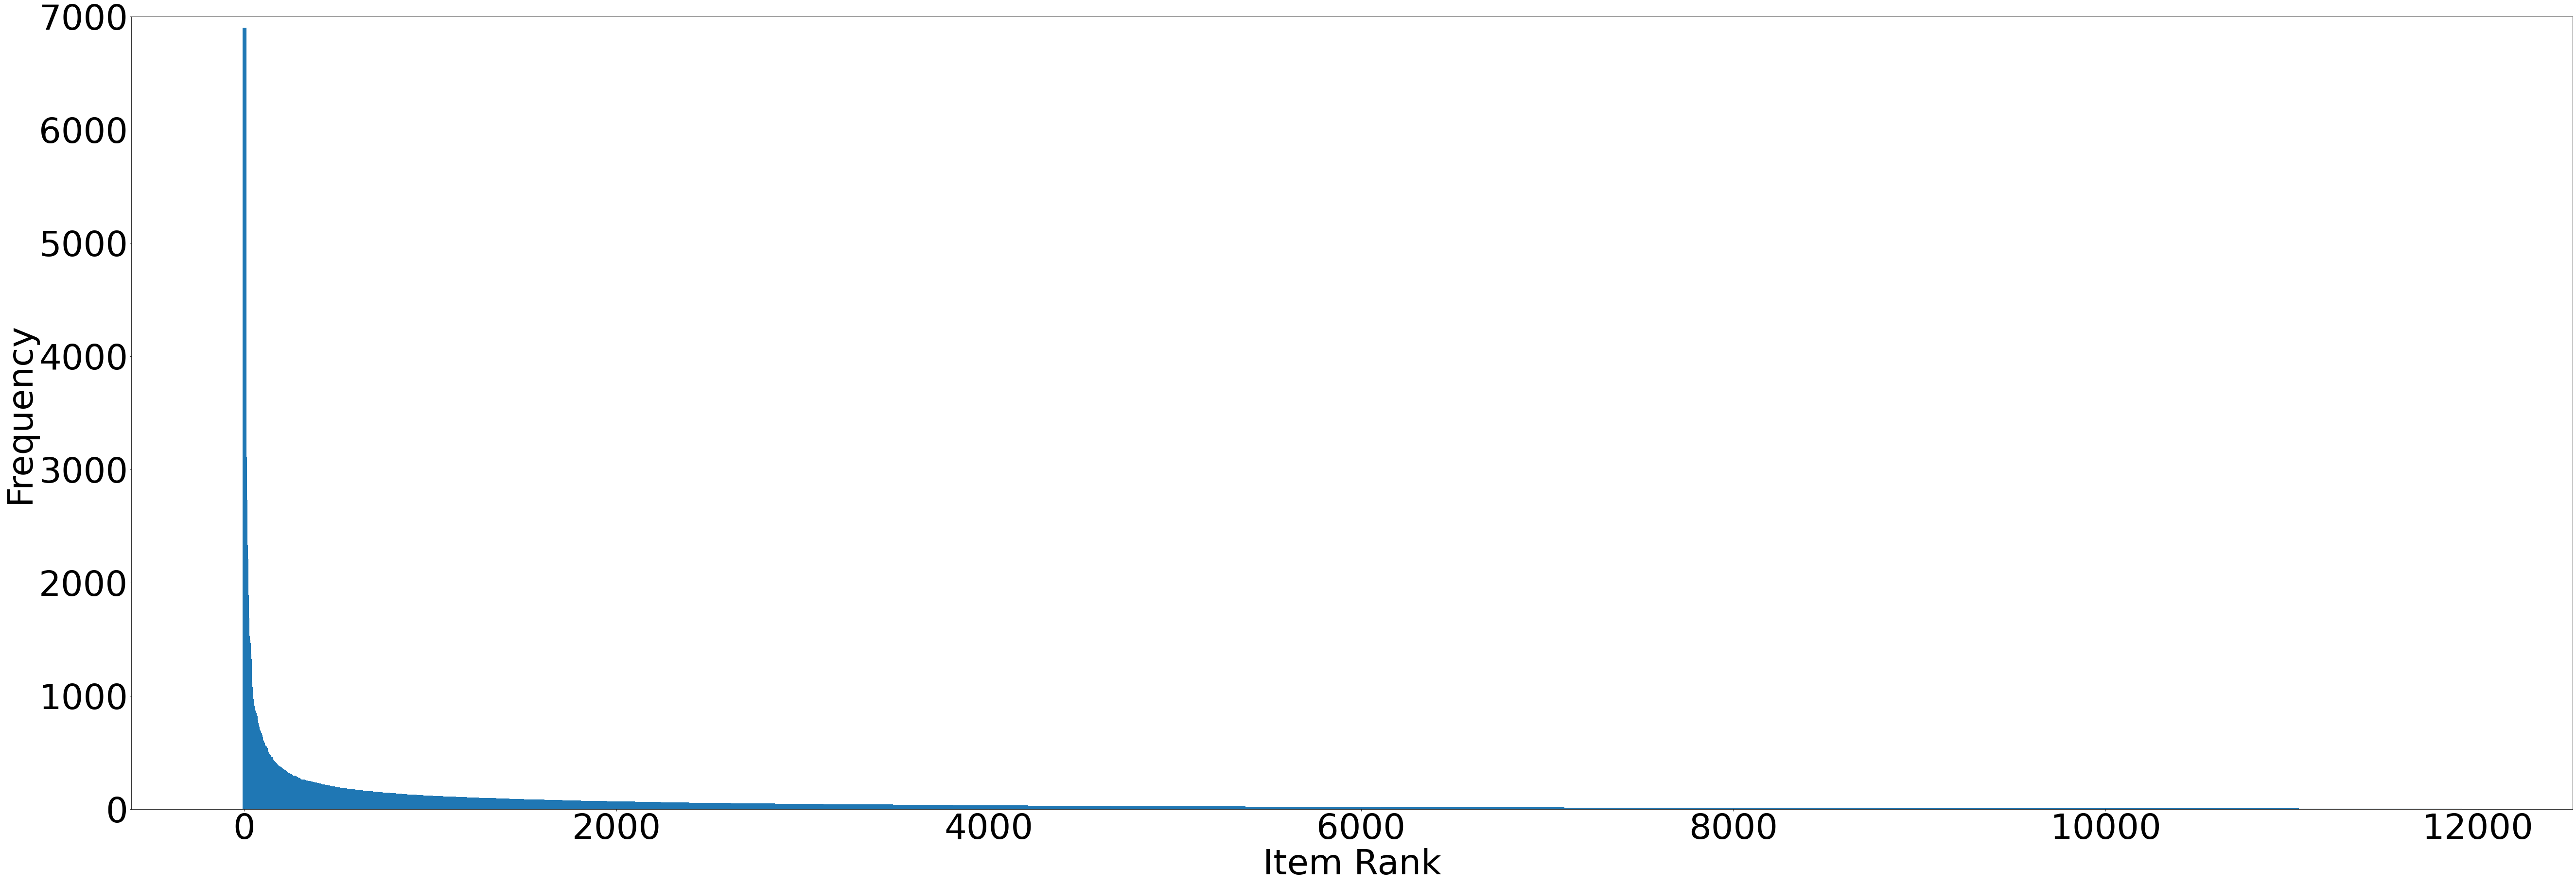

In [ ]:
plt.figure(figsize=(90,30))
font = {'size'   : 72}

plt.rc('font', **font)
plt.ylabel("Frequency")
plt.xlabel("Item Rank")
#plt.title("Item Rank, Frequency (1000 users) ")
plt.ylim([0, 7000])
plt.bar(popularity_ranking['item_rank'], popularity_ranking['total_prod_freq'], width=20.8)